## import packages

In [1]:
# import packages
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.metrics import confusion_matrix
import seaborn as sns
import cv2

## Download dataset and Visualize

In [2]:
import torch.utils
import torch.utils.data


transform = transforms.Compose([transforms.ToTensor(),
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

All_Train_dataset = torchvision.datasets.CIFAR10(root='../hw1/data', train=True, download=False, transform=transform)
Test_dataset = torchvision.datasets.CIFAR10(root='../hw1/data', train=False, download=False, transform=transform)

In [3]:
# Split Traindata and Validdata
from sklearn.model_selection import StratifiedShuffleSplit
train_labels = np.array(All_Train_dataset.targets)
test_labels = np.array(Test_dataset.targets)
# same proportion split dataset
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=12)


indics = np.array(len(train_labels))
train_indices, valid_indices = next(sss.split(np.zeros(indics), train_labels))

train_dataset = torch.utils.data.Subset(All_Train_dataset, train_indices)
valid_dataset = torch.utils.data.Subset(All_Train_dataset, valid_indices)

In [4]:
# np.bincount: Count the number of occurrences of different integers
print(np.bincount(train_labels[train_indices]))

[4000 4000 4000 4000 4000 4000 4000 4000 4000 4000]


# Visualize the distribution of the data and the images

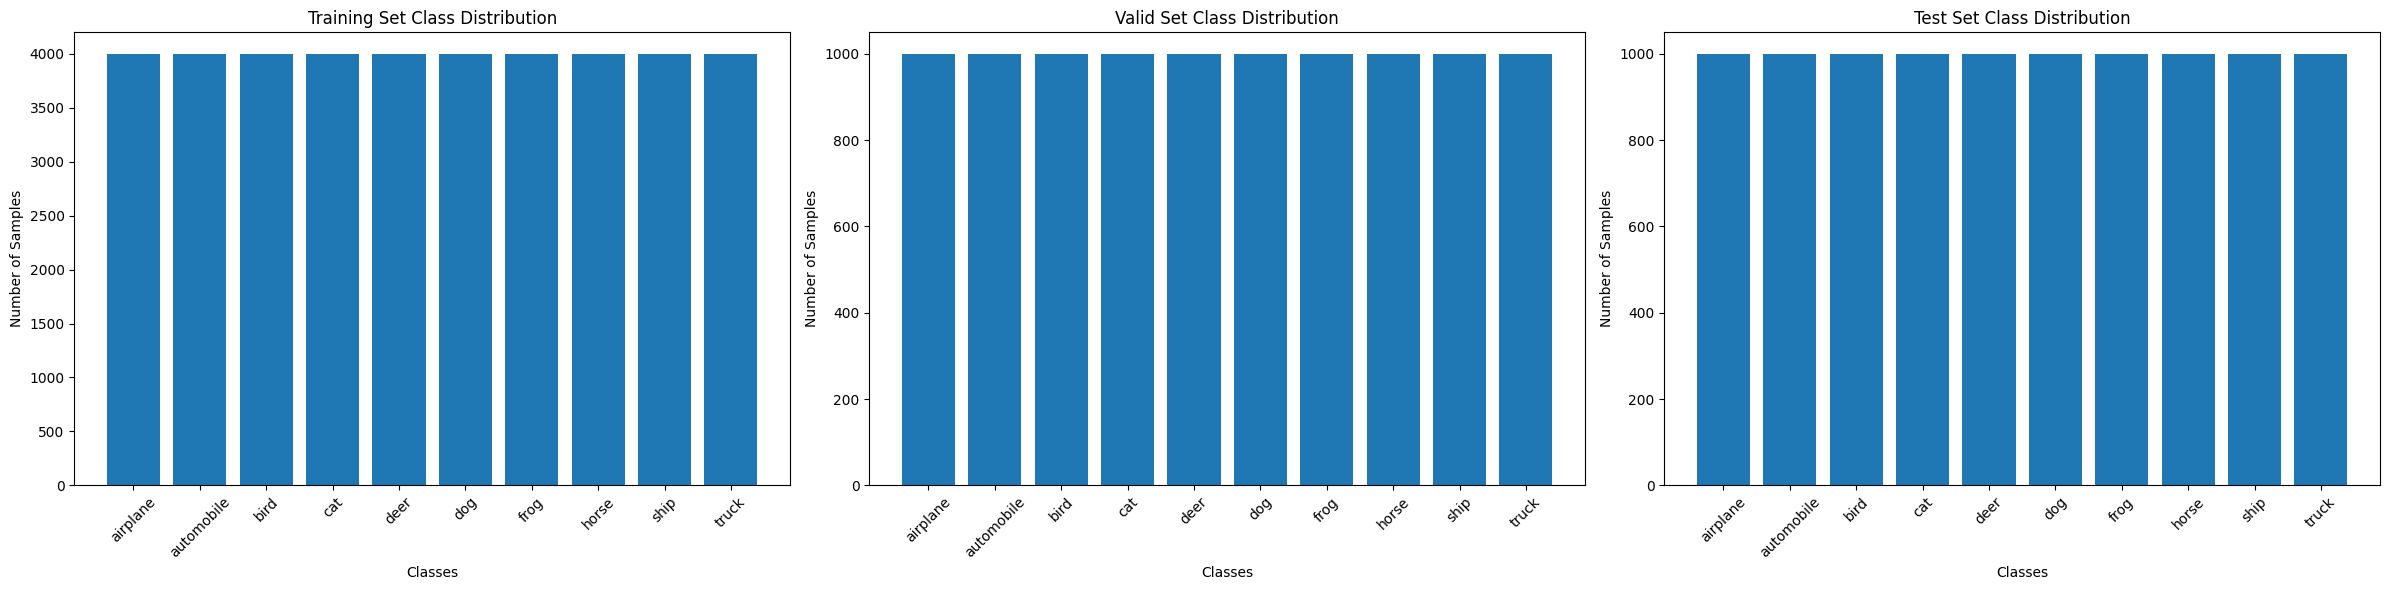

In [5]:
# Visualize the distribution of train dataset
# The CIFAR-10 dataset consists of 
# 60000 32x32 colour images
# 10 classes, 
# 6000 images per class.

# Visualization
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# Train class distribution
axes[0].bar(class_labels, np.bincount(train_labels[train_indices]))
axes[0].set_title('Training Set Class Distribution')
axes[0].set_xlabel('Classes')
axes[0].set_ylabel('Number of Samples')
axes[0].tick_params(axis='x', rotation=45)

# Valid class distribution
axes[1].bar(class_labels, np.bincount(train_labels[valid_indices]))
axes[1].set_title('Valid Set Class Distribution')
axes[1].set_xlabel('Classes')
axes[1].set_ylabel('Number of Samples')
axes[1].tick_params(axis='x', rotation=45)

# Test class distribution
axes[2].bar(class_labels, np.bincount(test_labels))
axes[2].set_title('Test Set Class Distribution')
axes[2].set_xlabel('Classes')
axes[2].set_ylabel('Number of Samples')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

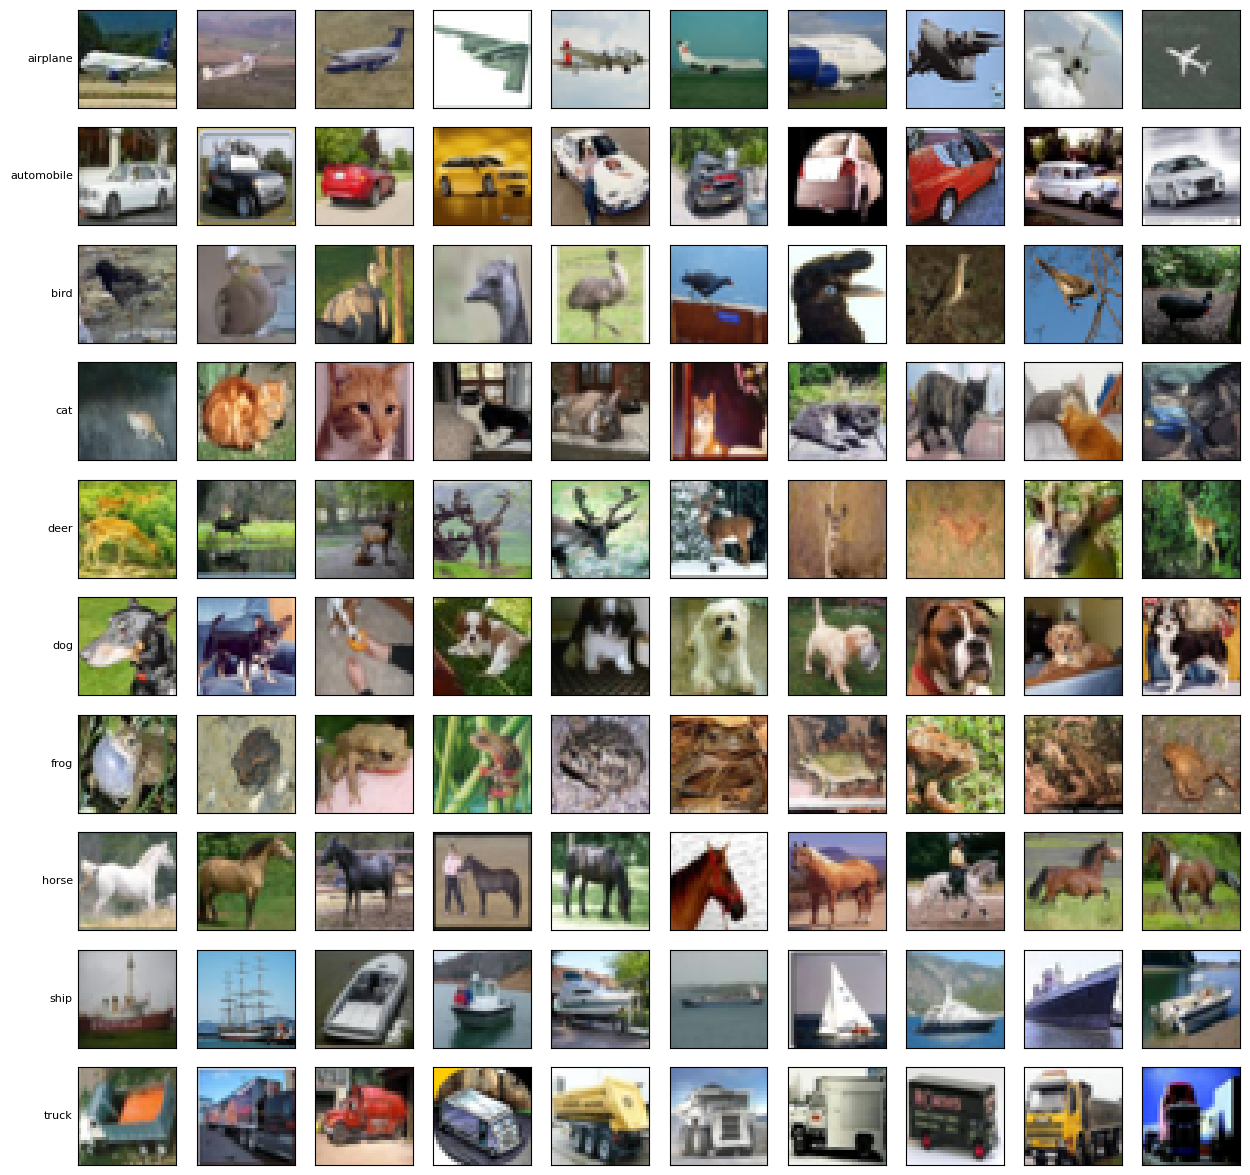

In [6]:
# store images by class
Train_class_images = {i: [] for i in range(10)}
for img, label in train_dataset:
    Train_class_images[label].append(img)

# visualize 10 images per class
num_images = 10
fig, axes = plt.subplots(10, num_images, figsize=(15, 15))

# Set y axis labels
y_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

for i in range(10):
    for j in range(num_images):
        # Restore image
        img = np.transpose((Train_class_images[i][j]*0.5 + 0.5).numpy(), (1, 2, 0))
        axes[i, j].imshow(img)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
    axes[i, 0].set_ylabel(y_labels[i], rotation=0, ha='right', va='center', fontsize=8)

plt.show()


In [7]:
def extract_edge_preprocess_data(dataset):
    images=[]
    labels=[]
    for img, label in dataset:
        # (C, H, W) -> (H, W, C)
        img_np = img.numpy().transpose(1, 2, 0)
        img_uint8 = (img_np * 255).astype(np.uint8)
        # Transform to grayscale map
        img_gray = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2GRAY)
        
        # Sobel
        sobel_x = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=3)
        sobel_y = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=3)
        
        # compute gradient and normalize
        edge_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
        edge_normalized = cv2.normalize(edge_magnitude, None, 0, 1, cv2.NORM_MINMAX)
        
        images.append(edge_normalized.flatten())
        labels.append(label)
        
    return np.array(images), np.array(labels)

### Implement KNN

In [8]:
def Knn_classifier(train_images, train_labels, test_images, k=5):
    predictions=[]
    for test_image in test_images:
        # 1. Compute Euclidean distance
        distances = np.sqrt(np.sum((train_images - test_images) ** 2), axis=1)
        # 2. Get indices of k nearest images
        nearest_indices = np.argpartition(distances, k)[:k]
        # 3. Get k labels
        nearest_labels = train_labels[nearest_indices]
        # 4. Get majority voting labels
        majority_label = Counter(nearest_labels).most_common(1)[0][0]
        predictions.append(majority_label)
    return np.array(predictions)

def Knn_classifier_cdist(train_images_tensor, train_labels, test_images_tensor, k=5):
    predictions=[]
    # 1. Compute Euclidean distance by torch.cdist
    distances = torch.cdist(test_images_tensor, train_images_tensor)
    # 2. Get indices of k nearest images
    nearest_indices = torch.topk(distances, k=k, largest=False, dim=1).indices
    # 3. Get k labels
    nearest_labels = train_labels[nearest_indices]
    # 4. Get majority voting labels
    for labels in nearest_labels:
        majority_label = Counter(labels).most_common(1)[0][0]
        predictions.append(majority_label)
    return np.array(predictions)

def Knn_classifier_cosine(train_images_tensor, train_labels, test_images_tensor, k=5):
    predictions = []
    
    # 1. normalize images to use cosine distance
    train_images_norm = train_images_tensor / torch.norm(train_images_tensor, dim=1, keepdim=True)
    test_images_norm = test_images_tensor / torch.norm(test_images_tensor, dim=1, keepdim=True)
    
    # 2. Compute consine distance
    similarities = torch.mm(test_images_norm, train_images_norm.T)  
    
    # 3. Get indices of k nearest images
    nearest_indices = torch.topk(similarities, k=k, largest=True, dim=1).indices
    # 4. Get k labels
    nearest_labels = train_labels[nearest_indices]
    
    # 5. Get majority voting labels
    for labels in nearest_labels:
        majority_label = Counter(labels).most_common(1)[0][0]
        predictions.append(majority_label)
    
    return np.array(predictions)

In [9]:
# Select best K by Valid dataset
def select_k(train_imges, train_labes, valid_images, valid_labels, model):
    best_k = None
    best_accuracy = 0
    for k in [1, 5, 10, 15]:
        val_pred = model(train_imges, train_labels, valid_images,k)
        accuracy = np.mean(val_pred == valid_labels)
        print(f"k={k}, Val accuracy: {accuracy:.4f}")
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_k = k
    
    print(f"Best k is {best_k}, and its accuracy is {best_accuracy}")
    return best_k

In [10]:
# transform data
def preprocess_data(dataset):
    images = []
    labels = []
    for img, label in dataset:
        images.append(img.numpy().flatten())
        labels.append(label)
    
    return np.array(images), np.array(labels)


# Train data
train_images, train_labels = preprocess_data(train_dataset)
train_images_tensor = torch.tensor(train_images, dtype=torch.float32)

# Valid data
valid_images, valid_labels = preprocess_data(valid_dataset)
valid_images_tensor = torch.tensor(valid_images, dtype=torch.float32)

# Test data   
test_images, test_labels = preprocess_data(Test_dataset)
test_images_tensor = torch.tensor(test_images, dtype=torch.float32)

k=1, Val accuracy: 0.3454
k=5, Val accuracy: 0.3501
k=10, Val accuracy: 0.3450
k=15, Val accuracy: 0.3393
Best k is 5, and its accuracy is 0.3501
Test accucacy is 0.3486 with k = 5


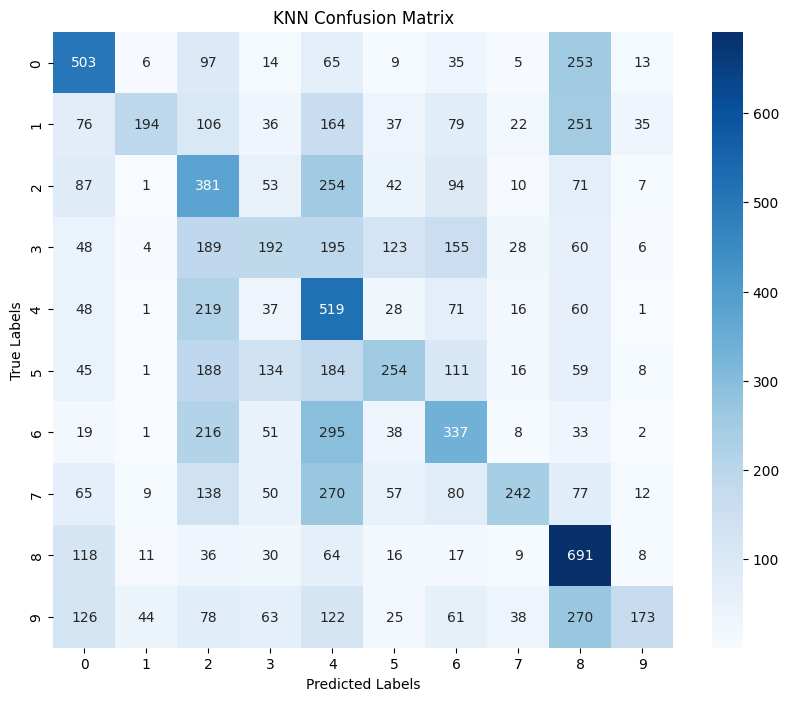

In [11]:
# Test KNN
best_k = select_k(train_images_tensor, train_labels, valid_images_tensor, valid_labels, Knn_classifier_cdist)

test_pred = Knn_classifier_cdist(train_images_tensor, train_labels, test_images_tensor, best_k)
test_acc = np.mean(test_pred == test_labels)

print(f"Test accucacy is {test_acc} with k = {best_k}")

# Compute confusion matrix
cm = confusion_matrix(test_labels, test_pred)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('KNN Confusion Matrix')
plt.show()

With sobel

k=1, Val accuracy: 0.2179
k=5, Val accuracy: 0.2341
k=10, Val accuracy: 0.2496
k=15, Val accuracy: 0.2499
Best k is 15, and its accuracy is 0.2499
Test accucacy is 0.2503 with k = 15


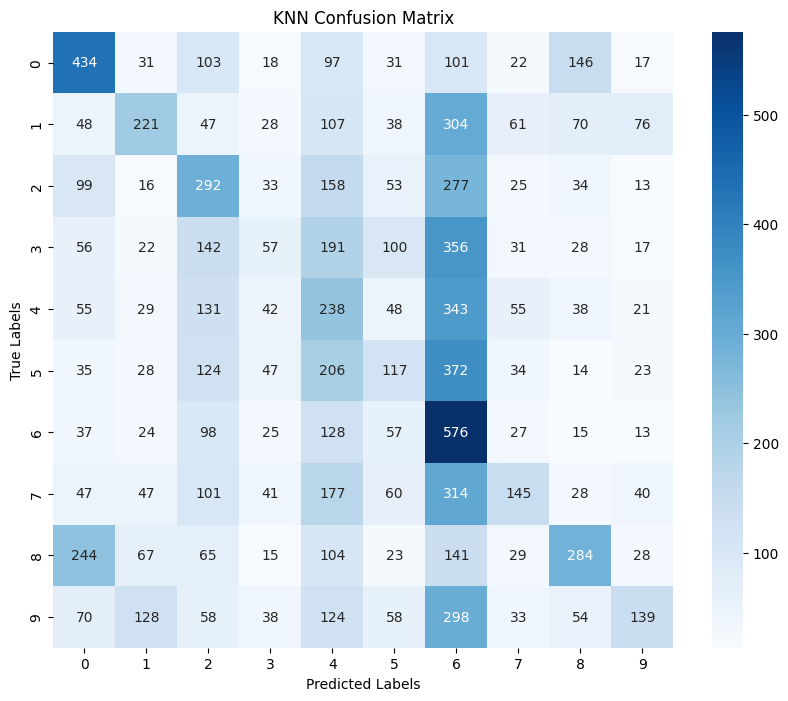

In [12]:
# transform data
def preprocess_data(dataset):
    images = []
    labels = []
    for img, label in dataset:
        images.append(img.numpy().flatten())
        labels.append(label)
    
    return np.array(images), np.array(labels)


# Train data
train_images, train_labels = extract_edge_preprocess_data(train_dataset)
train_images_tensor = torch.tensor(train_images, dtype=torch.float32)

# Valid data
valid_images, valid_labels = extract_edge_preprocess_data(valid_dataset)
valid_images_tensor = torch.tensor(valid_images, dtype=torch.float32)

# Test data   
test_images, test_labels = extract_edge_preprocess_data(Test_dataset)
test_images_tensor = torch.tensor(test_images, dtype=torch.float32)

# Test KNN
best_k = select_k(train_images_tensor, train_labels, valid_images_tensor, valid_labels, Knn_classifier_cdist)

test_pred = Knn_classifier_cdist(train_images_tensor, train_labels, test_images_tensor, best_k)
test_acc = np.mean(test_pred == test_labels)

print(f"Test accucacy is {test_acc} with k = {best_k}")

# Compute confusion matrix
cm = confusion_matrix(test_labels, test_pred)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('KNN Confusion Matrix')
plt.show()

### Implement Linear Classifier

In [16]:
# Load Batch data
from torch.utils.data import DataLoader,TensorDataset

X_train, y_train = extract_edge_preprocess_data(All_Train_dataset)
X_test, y_test = extract_edge_preprocess_data(Test_dataset)

train_images_tensor = torch.tensor(X_train, dtype=torch.float32)
train_labels_tensor = torch.tensor(y_train, dtype=torch.long)
test_images_tensor = torch.tensor(X_test, dtype=torch.float32)
test_labels_tensor = torch.tensor(y_test, dtype=torch.long)
batch_size = 1024
train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(test_images_tensor, test_labels_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [14]:
# Y = WX + B
# Data process is same
# Now we implement linear classifier with nn.Linear.
# And we also implement loss function with nn.CrossEntropyLoss().

# Implement Linear classifier with nn.Linear
import torch.nn as nn
import torch.optim as optim

class LinearClassifier(nn.Module):
    def __init__(self, d_input, d_features):
        super().__init__()
        # This is a Fully Connect layer
        self.linear = nn.Linear(d_input, d_features)
        
    def forward(self, x):
        x = x.view(x.size(0),-1) # (batch_sisze, 3, 32 32) -> (bach_size, 3*32*32)
        return self.linear(x)

    
d_input = train_images_tensor.shape[1]
num_classes = 10
model_LC = LinearClassifier(d_input, num_classes)

optimizer = optim.SGD(model_LC.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

def train(model, num_epoch):
    for epoch in range(num_epoch):
        model.train()
        batch_loss = 0
        for i, (images, labels) in enumerate(train_loader):
            output = model(images)
            loss = criterion(output, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            batch_loss += loss.item()
        if epoch % 5 == 0:
            print(f"epoch: {epoch}, loss:{batch_loss / len(train_loader)}")
            
def test(model):
    model.eval()
    correct = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            output = model(images)
            _, pred = torch.max(output.data, 1)
            correct += (pred == labels).sum().item()
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
        print(f"Test Accuracy: {100 * correct / len(test_loader.dataset):.2f}%")
        
        
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Visualization
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Linear classification Confusion Matrix')
    plt.show()

In [20]:
3*32*32

3072

epoch: 0, loss:2.2927134961498026
epoch: 5, loss:2.2173279937432735
epoch: 10, loss:2.1749801392457924
epoch: 15, loss:2.1478282724108015
Test Accuracy: 23.47%


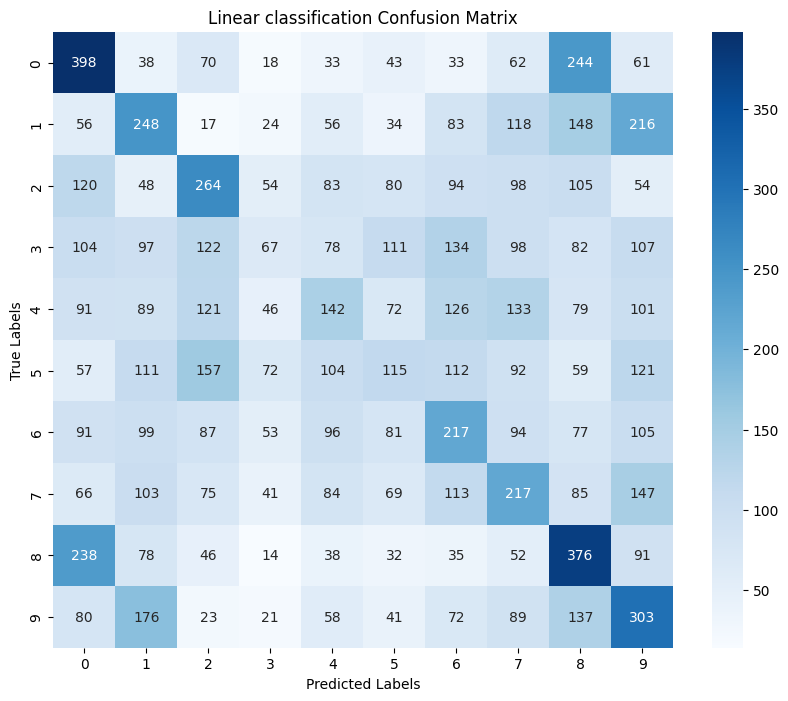

In [17]:
train(model_LC, 20)

test(model_LC)

### Implement SVM

Training Hard Margin SVM...
Hard Margin SVM Accuracy: 0.2951


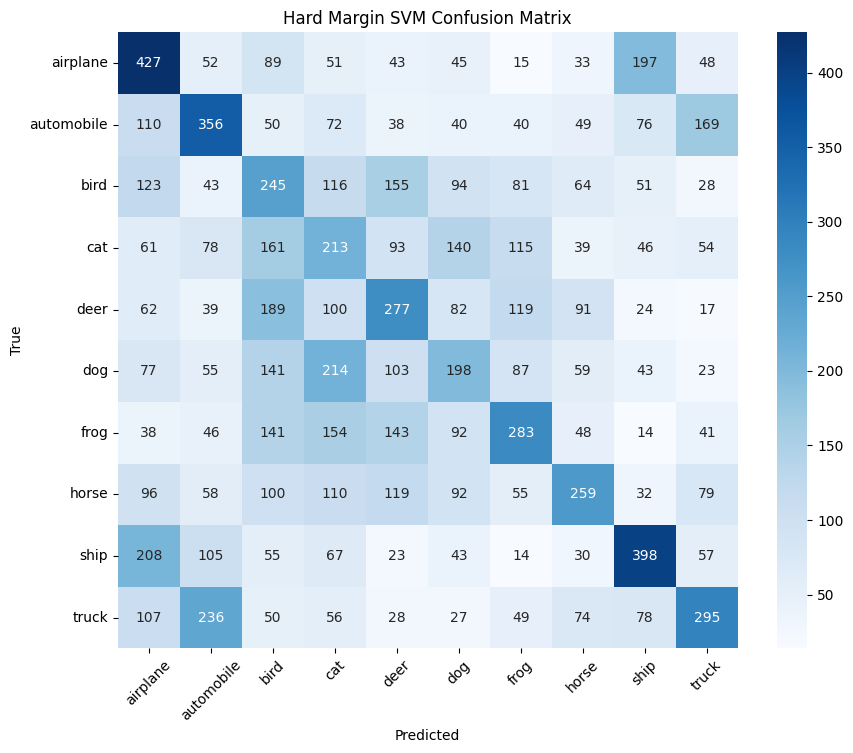


Training Soft Margin SVM...
Soft Margin SVM Accuracy: 0.2951


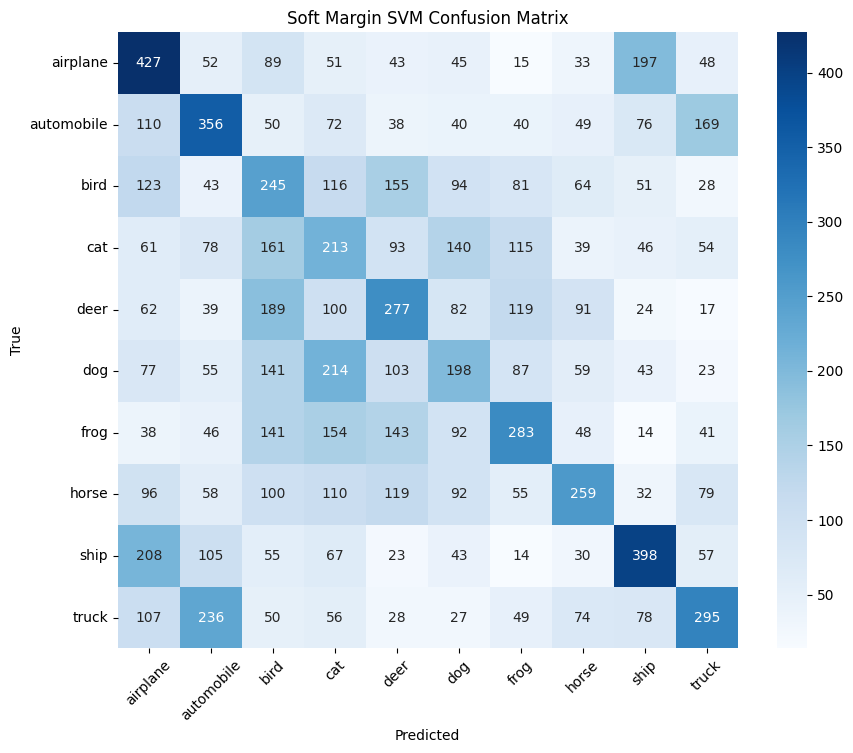


Training RBF Kernel SVM...
RBF Kernel SVM Accuracy: 0.4415


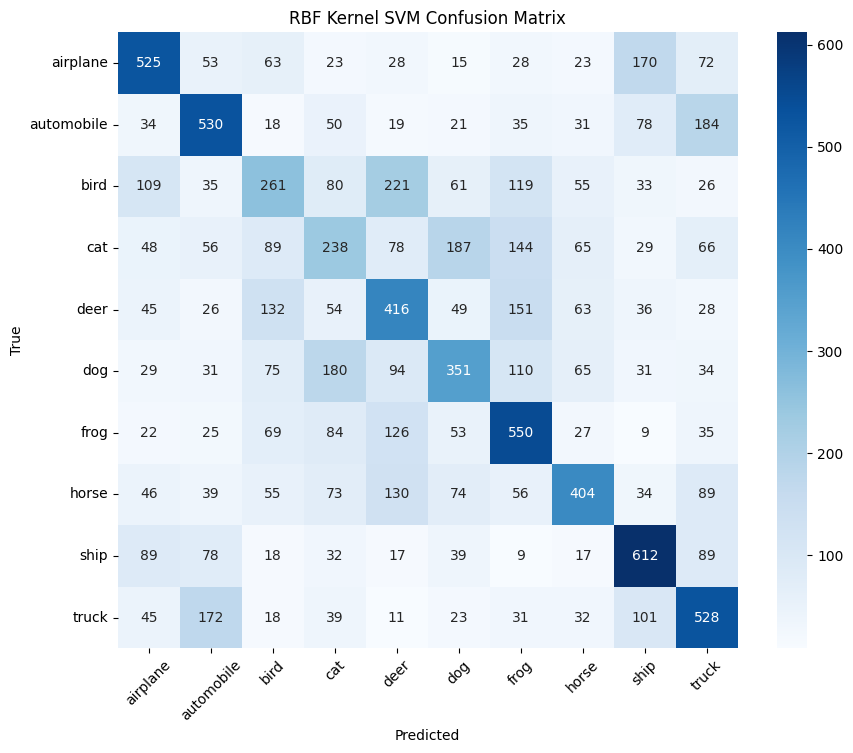

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import torchvision
import torch
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Lambda(lambda x: x.view(-1))
])

def dataset_to_numpy(dataset):
    data, labels = [], []
    for img, label in dataset:
        data.append(img.numpy())
        labels.append(label)
    return np.array(data), np.array(labels)

train_dataset = torchvision.datasets.CIFAR10(root='../hw1/data', train=True, download=False, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='../hw1/data', train=False, download=False, transform=transform)

X_train, y_train = dataset_to_numpy(train_dataset)
X_test, y_test = dataset_to_numpy(test_dataset)

# Decrease training data to decrease training time
sample_size = 5000
sss = StratifiedShuffleSplit(n_splits=1, train_size=sample_size, random_state=42)
for train_index, _ in sss.split(X_train, y_train):
    X_train_sub = X_train[train_index]
    y_train_sub = y_train[train_index]

# Standar data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sub)
X_test_scaled = scaler.transform(X_test)

def plot_confusion_matrix(y_true, y_pred, class_names, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

class_names = train_dataset.classes

# Train and evaluate the hard-margin SVM.
print("Training Hard Margin SVM...")
svm_hard = SVC(kernel='linear', C=1e10)
svm_hard.fit(X_train_scaled, y_train_sub)
y_pred_hard = svm_hard.predict(X_test_scaled)
print(f"Hard Margin SVM Accuracy: {accuracy_score(y_test, y_pred_hard):.4f}")
plot_confusion_matrix(y_test, y_pred_hard, class_names, 'Hard Margin SVM Confusion Matrix')

# Train and evaluate the soft-margin SVM.
print("\nTraining Soft Margin SVM...")
svm_soft = SVC(kernel='linear', C=1.0)
svm_soft.fit(X_train_scaled, y_train_sub)
y_pred_soft = svm_soft.predict(X_test_scaled)
print(f"Soft Margin SVM Accuracy: {accuracy_score(y_test, y_pred_soft):.4f}")
plot_confusion_matrix(y_test, y_pred_soft, class_names, 'Soft Margin SVM Confusion Matrix')

# Train and evaluate the Gaussian kernel SVM.
print("\nTraining RBF Kernel SVM...")
svm_rbf = SVC(kernel='rbf', C=1.0, gamma='scale')
svm_rbf.fit(X_train_scaled, y_train_sub)
y_pred_rbf = svm_rbf.predict(X_test_scaled)
print(f"RBF Kernel SVM Accuracy: {accuracy_score(y_test, y_pred_rbf):.4f}")
plot_confusion_matrix(y_test, y_pred_rbf, class_names, 'RBF Kernel SVM Confusion Matrix')

## Trying to Manul implemnt SVM

In [ ]:
from sklearn.decomposition import PCA

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Lambda(lambda x: x.view(-1))
])

def dataset_to_numpy(dataset):
    data, labels = [], []
    for img, label in dataset:
        data.append(img.numpy())
        labels.append(label)
    return np.array(data), np.array(labels)

train_dataset = torchvision.datasets.CIFAR10(root='../hw1/data', train=True, download=False, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='../hw1/data', train=False, download=False, transform=transform)

X_train, y_train = dataset_to_numpy(train_dataset)
X_test, y_test = dataset_to_numpy(test_dataset)

# PCA
# Use Principal component analysis to decrease data dimension
# In order to get less training time, we want to decrease data dimension (D) to decrease compute complexity O(N * D)
subset_size = 5000
X_train_subset = X_train[:subset_size]
y_train_subset = y_train[:subset_size]

pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [ ]:
# core of SVM is decision edge and distance between the edge and nearest sample
# So our goal is to find decision edge
class SVM():
    def __init__(self, iters, lr, lambda_param):
        self.num_iters = iters
        self.learning_rate = lr
        self.lambda_p = lambda_param
        self.w = None
        self.b = None
        
    def fit(self, X, y):
        n_samples, features = X.shape
        
        self.w = np.zeros(features)
        self.b = 0
        
        for _ in range(self.num_iters):
            # for _ in enumerate(X):
            #     # Judge outcome of classifying x
            #     # y*(wx-b) >= 1 is right else is falss
            #     outcome = y[idx] * (np.dot(x_i, self.w) - self.b) >= 1
            #     # Compute loss
            #     # loss = lambda*||x||^2 + labda*sum(max(0, 1-y_i*(wx_i-b)))
            #     # 1. right -> 1/Nsum(max(0, 1-y_i*(wx_i-b)))==0
            #     # 2. false -> 1/Nsum(max(0, 1-y_i*(wx_i-b)))==-y_ix_i
            #     if outcome:
            #         # Update Norm item ot increase distance between decision edge and sample.
            #         self.w -= self.learning_rate * (2 * self.lambda_p * self.w)
            #     else:
            #         # Update w and b to find currect decision edge
            #         self.w -= self.learning_rate * (2 * self.lambda_p * self.w - np.dot(x_i, y[idx]))
            #         self.b -= self.learning_rate * self.lambda_p * y[idx]
            
            # Using matrix parallel computing gradient
            margins = y * (np.dot(X, self.w) - self.b)
            violations = margins < 1
            
            grad_w = (2 * self.lambda_p * self.w) - (X[violations] * y[violations, np.newaxis]).sum(axis=0) / n_samples
            grad_b = -y[violations].mean()
            
            self.w -= self.learning_rate * grad_w
            self.b -= self.learning_rate * grad_b
    
    def predict(self, X):
        linear_out = np.dot(X, self.w) - self.b
        return np.sign(linear_out)
    
# One-vs-Rest
# Use 10 SVM classifiers to classity 10 classes 
# finally we choose the highest predict score to be predicted class
class MultiClassSVM():
    def __init__(self, iters=1000, lr=0.01, lambda_param=0.1):
        self.num_iters = iters
        self.lr = lr
        self.lambda_p = lambda_param
        self.classifiers = []
        
    def fit(self, X, y):
        self.classes = np.unique(y)
        # Training 10 svm classifiers
        for i, cls in enumerate(self.classes):
            print(f"Training {i}_th svm")
            y_binary = np.where(y == cls, 1, -1)
            svm = SVM(self.num_iters, self.lr, self.lambda_p)
            svm.fit(X, y_binary)
            self.classifiers.append(svm)
            print(f"Trained {i}_th svm")
    
    def predict(self, X):
        scores = np.array([svm.predict(X) for svm in self.classifiers])
        return self.classes[np.argmax(scores, axis=0)]
        

In [ ]:
multiclass_svm = MultiClassSVM()
multiclass_svm.fit(X_train_pca, y_train)
y_pred = multiclass_svm.predict(X_test_pca)
accuracy = np.mean(y_pred == y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

在本次实验中，对比了线性分类器和非线性分类器对CIFAR10数据集的分类任务，
首先从任务来看，CIFAR10 数据集中的图像数据具有复杂的特征和非线性关系，这是一个典型的非线性分类问题。
从结果来看，KNN难以利用到图像高维数据的关系，而且在训练过程中K值的选择比较困难，需要不断进行测试。\
线性分类模型的结构相对简单，训练和预测的计算复杂度较低。在处理大规模数据集时，线性分类算法比一些复杂的非线性模型（如 KNN）具有更高的计算效率，能够更快地完成训练和预测任务,但它也有着与KNN类似的缺陷，它只能学习数据的线性关系，对于复杂的非线性数据分布，其分类性能较差。\
相比于前两者来说，SVM 通过核技巧可以将低维空间中的非线性问题转化为高维空间中的线性问题，从而有效地处理复杂的非线性数据。在 CIFAR - 10 数据集上，SVM 可以利用核函数（如径向基函数 RBF）来学习图像数据中的非线性特征，提高分类的准确性。
